In [14]:
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
import pandas as pd
import numpy as np 
import scipy.stats as stats
from collections import Counter
import matplotlib.pyplot as plt
import umap
import matplotlib
import mygene
%matplotlib inline
import pickle
import sklearn
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier
# import sentence_transformers
plt.style.use('ggplot')
#plt.style.use('seaborn-v0_8-dark-palette')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [15]:
with open(f"/Users/yiquntchen/Downloads/data_embedding/GPT_3_5_gene_embeddings.pickle", "rb") as fp:
    GPT_3_5_gene_embeddings = pickle.load(fp)

In [16]:
# Create random embeddings as negative controls
np.random.seed(2023)
N_DIM = 1536
fake_pretrain_embed = dict()
for key in GPT_3_5_gene_embeddings.keys():
    fake_pretrain_embed[key] = np.random.normal(size=(N_DIM))

### Long- vs short- range TFs
The input data used here are downloaded from Chen et al. (2020) (link: https://www-nature-com.stanford.idm.oclc.org/articles/s41467-020-16106-x).

In [17]:
long_short_range_tf = pd.read_csv('~/Downloads/41467_2020_16106_MOESM4_ESM.csv')
long_range_tf_gene = list(long_short_range_tf[long_short_range_tf['assignment']=='long-range TF']\
                                ['Unnamed: 0'])
short_range_tf_gene = list(long_short_range_tf[long_short_range_tf['assignment']=='short-range TF']\
                                ['Unnamed: 0'])
x_long_range_tf = [GPT_3_5_gene_embeddings[x] for x in long_range_tf_gene \
               if x in GPT_3_5_gene_embeddings]
x_short_range_tf =  [GPT_3_5_gene_embeddings[x] for x in short_range_tf_gene\
               if x in GPT_3_5_gene_embeddings]

In [18]:
# bivalent versus non-methylated
np.random.seed(2023)
random.seed(2023)

# Assuming x and y are your data
# For demonstration, let's create some dummy data.
# Ensure your data is in NumPy array format for compatibility
X_array = np.concatenate((x_long_range_tf,x_short_range_tf))
y_array =  np.concatenate((np.repeat(1,len(x_long_range_tf)),np.repeat(0,len(x_short_range_tf))))

# Set up Stratified K-Folds cross-validator
# It provides train/test indices to split data into train/test sets
cv = StratifiedKFold(n_splits=5)

# Lists to store ROC AUC scores for each fold
roc_auc_logistic = []
roc_auc_rf = []

# Lists to store TPR and FPR for each fold
tpr_logistic = []
fpr_logistic = []
tpr_rf = []
fpr_rf = []

for train_index, test_index in cv.split(X_array, y_array):
    X_train, X_test = X_array[train_index], X_array[test_index]
    y_train, y_test = y_array[train_index], y_array[test_index]

    # Logistic Regression
    logistic_model = LogisticRegression()
    logistic_model.fit(X_train, y_train)
    y_score_logistic = logistic_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score_logistic)
    roc_auc = auc(fpr, tpr)
    roc_auc_logistic.append(roc_auc)
    tpr_logistic.append(tpr)
    fpr_logistic.append(fpr)

    # Random Forest
    random_forest_model = RandomForestClassifier()
    random_forest_model.fit(X_train, y_train)
    y_score_rf = random_forest_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score_rf)
    roc_auc = auc(fpr, tpr)
    roc_auc_rf.append(roc_auc)
    tpr_rf.append(tpr)
    fpr_rf.append(fpr)

# Print ROC AUC scores
print(f"Logistic Regression ROC AUC: {np.mean(roc_auc_logistic):.3f} +/- {np.std(roc_auc_logistic):.3f}")
print(f"Random Forest ROC AUC: {np.mean(roc_auc_rf):.3f} +/- {np.std(roc_auc_rf):.3f}")


Logistic Regression ROC AUC: 0.726 +/- 0.261
Random Forest ROC AUC: 0.635 +/- 0.070


## Dosage sensitive vs insensitive TFs

In [20]:
link_file = "https://huggingface.co/datasets/ctheodoris/Genecorpus-30M/raw/main/example_input_files/gene_classification/dosage_sensitive_tfs/dosage_sens_tf_labels.csv"
dosage_tfs = pd.read_csv(link_file, header=0)
sensitive = dosage_tfs["dosage_sensitive"].dropna()
insensitive = dosage_tfs["dosage_insensitive"].dropna()

In [21]:
mg = mygene.MyGeneInfo()
sensitive_query = mg.querymany(sensitive, species='human')
in_sensitive_query = mg.querymany(insensitive, species='human')
sensitive_gene_name = [x['symbol'] for x in sensitive_query]
in_sensitive_gene_name = [x['symbol'] for x in in_sensitive_query if 'symbol' in x]

INFO:biothings.client:querying 1-122...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-368...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [22]:
x_sensitive = [GPT_3_5_gene_embeddings[name] for name in sensitive_gene_name\
               if name in GPT_3_5_gene_embeddings]
x_insensitive = [GPT_3_5_gene_embeddings[name] for name in in_sensitive_gene_name \
                 if name in GPT_3_5_gene_embeddings]
x_dosage = x_sensitive.copy()
x_dosage.extend(x_insensitive)
y_dosage = np.concatenate((np.repeat(1,len(x_sensitive)),np.repeat(0,len(x_insensitive))))

In [23]:
np.random.seed(2023)
random.seed(2023)

# Ensure your data is in NumPy array format for compatibility
X_array = np.array(x_dosage)
y_array = np.array(y_dosage)


# Set up Stratified K-Folds cross-validator
# It provides train/test indices to split data into train/test sets
cv = StratifiedKFold(n_splits=5)

# Lists to store ROC AUC scores for each fold
roc_auc_logistic = []
roc_auc_rf = []

# Lists to store TPR and FPR for each fold
tpr_logistic = []
fpr_logistic = []
tpr_rf = []
fpr_rf = []

for train_index, test_index in cv.split(X_array, y_array):
    X_train, X_test = X_array[train_index], X_array[test_index]
    y_train, y_test = y_array[train_index], y_array[test_index]

    # Logistic Regression
    logistic_model = LogisticRegression()
    logistic_model.fit(X_train, y_train)
    y_score_logistic = logistic_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score_logistic)
    roc_auc = auc(fpr, tpr)
    roc_auc_logistic.append(roc_auc)
    tpr_logistic.append(tpr)
    fpr_logistic.append(fpr)

    # Random Forest
    random_forest_model = RandomForestClassifier()
    random_forest_model.fit(X_train, y_train)
    y_score_rf = random_forest_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score_rf)
    roc_auc = auc(fpr, tpr)
    roc_auc_rf.append(roc_auc)
    tpr_rf.append(tpr)
    fpr_rf.append(fpr)

# Print ROC AUC scores
print(f"Logistic Regression ROC AUC: {np.mean(roc_auc_logistic):.3f} +/- {np.std(roc_auc_logistic):.3f}")
print(f"Random Forest ROC AUC: {np.mean(roc_auc_rf):.3f} +/- {np.std(roc_auc_rf):.3f}")


Logistic Regression ROC AUC: 0.889 +/- 0.030
Random Forest ROC AUC: 0.899 +/- 0.031


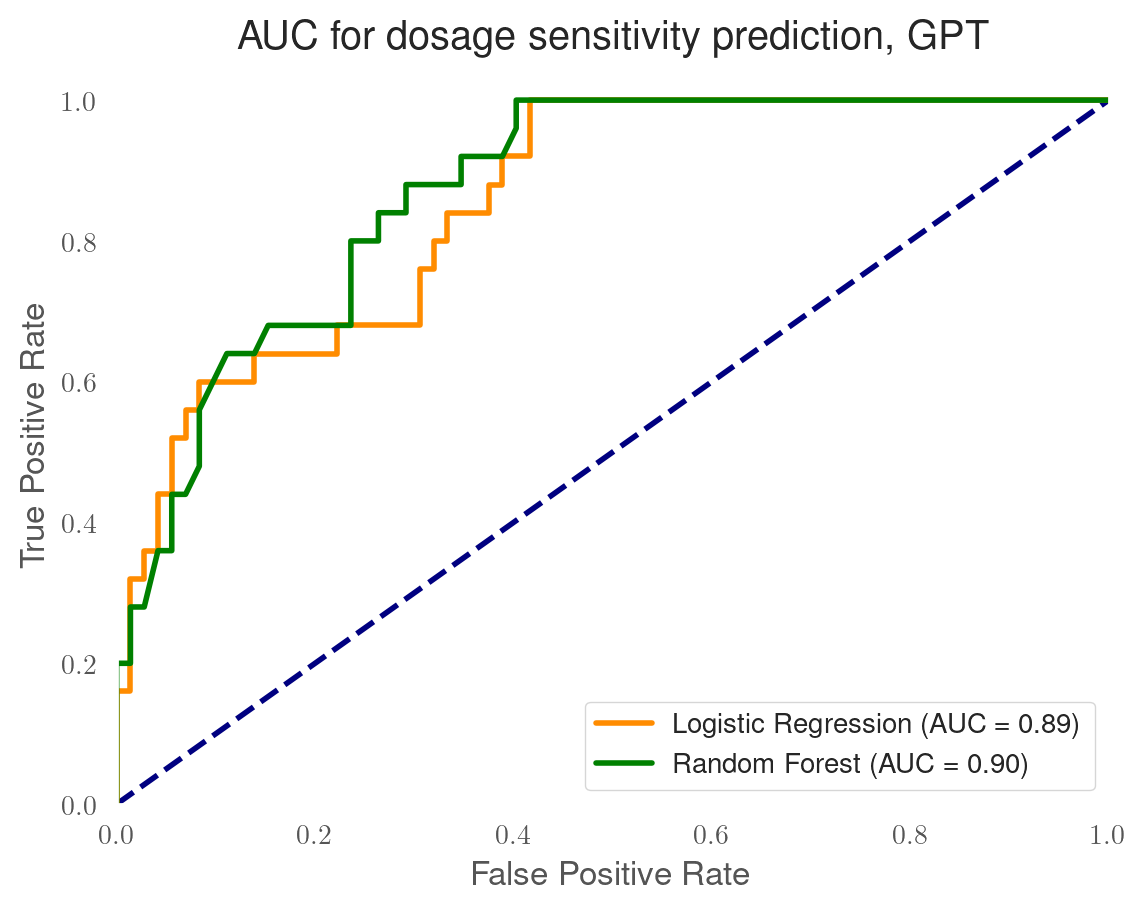

In [24]:
# Plot ROC curves
plt.figure()
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot(fpr_logistic[0], tpr_logistic[0], color='darkorange', lw=2, label='Logistic Regression (AUC = %0.2f)' % np.mean(roc_auc_logistic))
plt.plot(fpr_rf[0], tpr_rf[0], color='green', lw=2, label='Random Forest (AUC = %0.2f)' % np.mean(roc_auc_rf))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC for dosage sensitivity prediction, GPT')
plt.legend(loc='lower right')
plt.show()

## Methylation state prediction
The csv files are downloaded from https://huggingface.co/datasets/ctheodoris/Genecorpus-30M/

In [25]:
bivalent_gene_labels = pd.read_csv('~/Downloads/bivalent_gene_labels.txt',header=None)
no_methylation_gene_labels = pd.read_csv('~/no_methylation_gene_labels.txt',header=None)
lysine_gene_labels = pd.read_csv('~/Downloads/lys4_only_gene_labels.txt',header=None)

In [26]:
bivalent_query = mg.querymany(list(bivalent_gene_labels[0]), species='human')
no_methylation_query = mg.querymany(list(no_methylation_gene_labels[0]), species='human')
lysine_query = mg.querymany(list(lysine_gene_labels[0]), species='human')

INFO:biothings.client:querying 1-107...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.
INFO:biothings.client:querying 1-42...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.
INFO:biothings.client:querying 1-80...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [28]:
x_bivalent = [GPT_3_5_gene_embeddings[x['symbol']] for x in bivalent_query\
               if 'symbol' in x and x['symbol'] in GPT_3_5_gene_embeddings]
x_no_methylation = [GPT_3_5_gene_embeddings[x['symbol']] for x in no_methylation_query\
               if 'symbol' in x and  x['symbol'] in GPT_3_5_gene_embeddings]
x_lysine = [GPT_3_5_gene_embeddings[x['symbol']] for x in lysine_query\
                if 'symbol' in x and  x['symbol'] in GPT_3_5_gene_embeddings]

### Bivalent versus non-methylated

In [29]:
# bivalent versus non-methylated
np.random.seed(2023)
random.seed(2023)

X_array = np.concatenate((x_bivalent,x_no_methylation))
y_array =  np.concatenate((np.repeat(1,len(x_bivalent)),np.repeat(0,len(x_no_methylation))))

# Set up Stratified K-Folds cross-validator
# It provides train/test indices to split data into train/test sets
cv = StratifiedKFold(n_splits=5)

# Lists to store ROC AUC scores for each fold
roc_auc_logistic = []
roc_auc_rf = []

# Lists to store TPR and FPR for each fold
tpr_logistic = []
fpr_logistic = []
tpr_rf = []
fpr_rf = []

for train_index, test_index in cv.split(X_array, y_array):
    X_train, X_test = X_array[train_index], X_array[test_index]
    y_train, y_test = y_array[train_index], y_array[test_index]

    # Logistic Regression
    logistic_model = LogisticRegression()
    logistic_model.fit(X_train, y_train)
    y_score_logistic = logistic_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score_logistic)
    roc_auc = auc(fpr, tpr)
    roc_auc_logistic.append(roc_auc)
    tpr_logistic.append(tpr)
    fpr_logistic.append(fpr)

    # Random Forest
    random_forest_model = RandomForestClassifier()
    random_forest_model.fit(X_train, y_train)
    y_score_rf = random_forest_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score_rf)
    roc_auc = auc(fpr, tpr)
    roc_auc_rf.append(roc_auc)
    tpr_rf.append(tpr)
    fpr_rf.append(fpr)

# Print ROC AUC scores
print(f"Logistic Regression ROC AUC: {np.mean(roc_auc_logistic):.3f} +/- {np.std(roc_auc_logistic):.3f}")
print(f"Random Forest ROC AUC: {np.mean(roc_auc_rf):.3f} +/- {np.std(roc_auc_rf):.3f}")


Logistic Regression ROC AUC: 0.912 +/- 0.062
Random Forest ROC AUC: 0.922 +/- 0.059


### bivalent versus lys-4 methylated

In [30]:
np.random.seed(2023)
random.seed(2023)

# Assuming x and y are your data
# For demonstration, let's create some dummy data.
# Ensure your data is in NumPy array format for compatibility
X_array = np.concatenate((x_bivalent,x_lysine))
y_array =  np.concatenate((np.repeat(1,len(x_bivalent)),np.repeat(0,len(x_lysine))))

# Set up Stratified K-Folds cross-validator
# It provides train/test indices to split data into train/test sets
cv = StratifiedKFold(n_splits=5)

# Lists to store ROC AUC scores for each fold
roc_auc_logistic = []
roc_auc_rf = []
roc_auc_xgb = []

# Lists to store TPR and FPR for each fold
tpr_logistic = []
fpr_logistic = []
tpr_rf = []
fpr_rf = []

for train_index, test_index in cv.split(X_array, y_array):
    X_train, X_test = X_array[train_index], X_array[test_index]
    y_train, y_test = y_array[train_index], y_array[test_index]

    # Logistic Regression
    logistic_model = LogisticRegression()
    logistic_model.fit(X_train, y_train)
    y_score_logistic = logistic_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score_logistic)
    roc_auc = auc(fpr, tpr)
    roc_auc_logistic.append(roc_auc)
    tpr_logistic.append(tpr)
    fpr_logistic.append(fpr)

    # Random Forest
    random_forest_model = RandomForestClassifier()
    random_forest_model.fit(X_train, y_train)
    y_score_rf = random_forest_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score_rf)
    roc_auc = auc(fpr, tpr)
    roc_auc_rf.append(roc_auc)
    tpr_rf.append(tpr)
    fpr_rf.append(fpr)


# Print ROC AUC scores
print(f"Logistic Regression ROC AUC: {np.mean(roc_auc_logistic):.3f} +/- {np.std(roc_auc_logistic):.3f}")
print(f"Random Forest ROC AUC: {np.mean(roc_auc_rf):.3f} +/- {np.std(roc_auc_rf):.3f}")

Logistic Regression ROC AUC: 0.941 +/- 0.034
Random Forest ROC AUC: 0.952 +/- 0.036
